In [2]:
from thinkbayes2 import Pmf, Cdf, Suite, MakeJoint
import thinkplot

import pymc3 as pm
import numpy as np
import pandas as pd

from pymc3.math import exp, log

/Users/sam/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def plotCdf(values, *args, **kwargs):
    thinkplot.Cdf(Cdf(values), *args, **kwargs)

# Problem Description
In the 2018 season of Major League Baseball...

We want to estimate which team is the best team, and ...

To accomplish this, we build an object-oriented PyMC model that predicts the expected number of runs scored by a given team in a game against another team. The model also includes mechanisms for representing properties of Baseball as a game, allowing it to build a Bayesian estimate of the mean score in a baseball game and the additional runs that a team is expected to get from having home field advantage.

In [4]:
class Baseball(object):
    """
    A Baseball object contains properties about fundamental properties of 
    the sport of Baseball itself, represented with PyMC3 distributions.
    """
    
    def __init__(self, name='baseball'):
        self.name = name
        
        self.mean_score = pm.Normal(f'{name}.mean_score', mu=4.5, sd=1) # Based on Sam's guess
        self.home_field_advantage = pm.Exponential(f'{name}.home_field_advantage', lam=3)  # goals

The model we use for runs is a Poisson process with parameter dependent on the skills of both teams, as well as which team has home field advantage. In particular, we model the expected number of runs a given team will score in a game as 

$$k_{baseball} * \frac{e^{skill_{you}}}{e^{skill_{opponent}}} + home_field_boost$$

where

\begin{cases} 
      home_field_boost =  & x\leq 0 \\
      \frac{100-x}{100} & 0\leq x\leq 100 \\
      0 & 100\leq x 
   \end{cases}

In [5]:
class Team(object):
    def __init__(self, name, baseball):
        self.name = name
        self.baseball = baseball
        
        self.quality = pm.Normal(f'{name}.quality', mu=0, sd=1)
        
    def model_game(self, opponent, homefield : bool, observed_runs=None, name=None):
        if not name:
            name = f'{self.name}_v_{opponent.name}'
            
        expected_runs = self.baseball.mean_score * (exp(self.quality) / exp(opponent.quality))
        
        if homefield:
            expected_runs += self.baseball.home_field_advantage
        
        pm.Poisson(name, mu=expected_runs, observed=observed_runs)


In [24]:
team_names = ['BOS', 'NYY', 'TBR', 'TOR', 'BAL']
team_games = {}
for team in team_names:
    data = pd.read_csv(f'../data/{team.lower()}.csv')
    df = data[['Opp', 'Unnamed: 4', 'R', 'RA']]
    df = df.loc[df['Opp'].isin(team_names)]
    df = df.rename(index=str, columns={'Unnamed: 4': 'Home'})
    df['Home'] = df['Home'].apply(lambda x: False if x == '@' else True)
    team_games[team] = df


In [33]:
with pm.Model() as model:
    bb = Baseball()

    teams = {name: Team(name, bb) for name in team_names}

    for name, games in team_games.items():
        for index, game in games.head(10).iterrows():
            teams[name].model_game(teams[game['Opp']], game['Home'], game['R'], name=f'{name}_{index}')

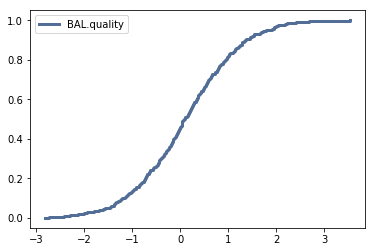

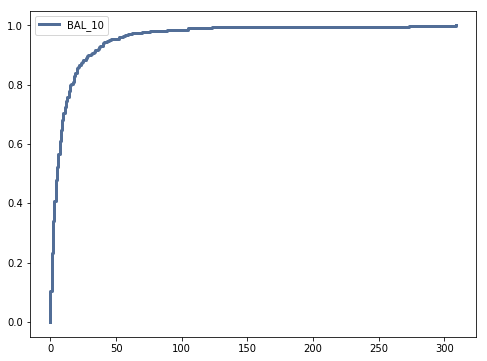

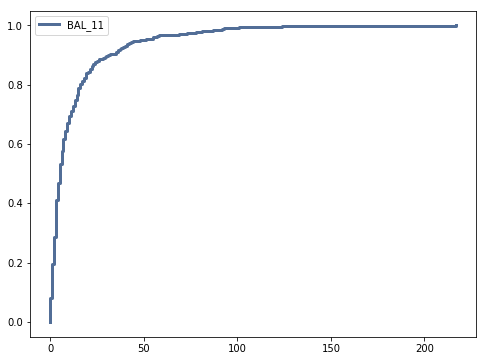

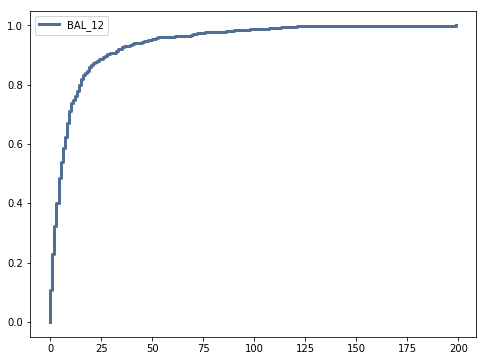

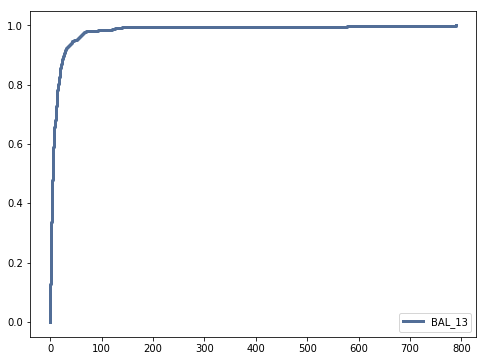

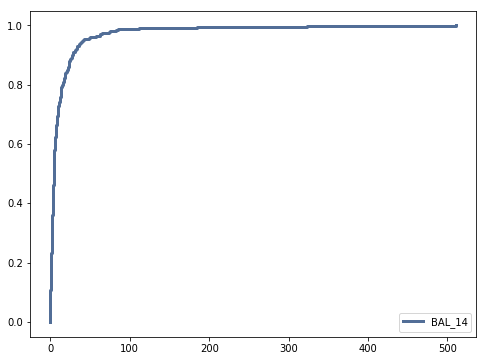

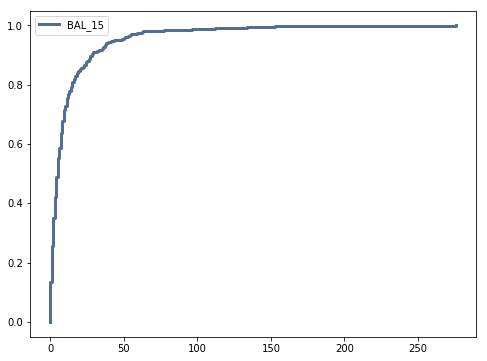

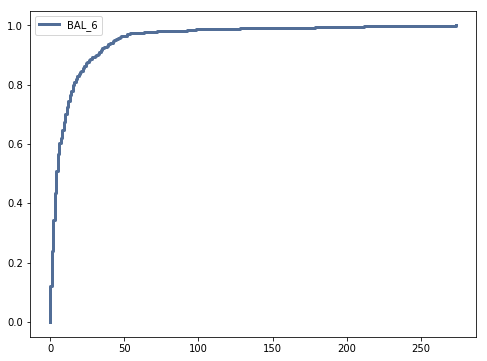

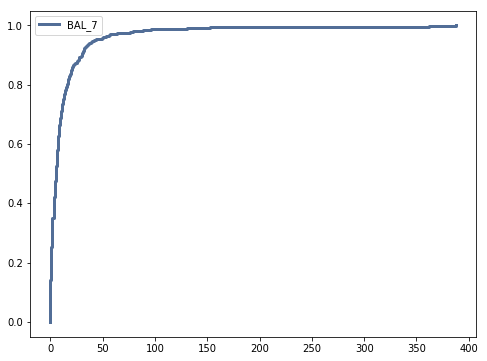

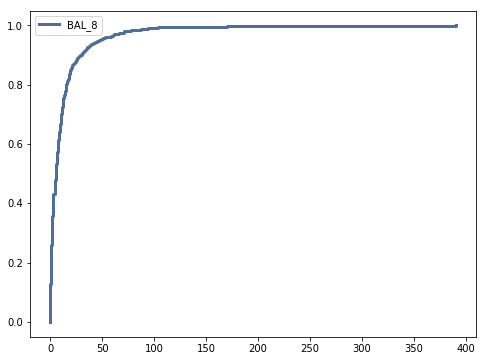

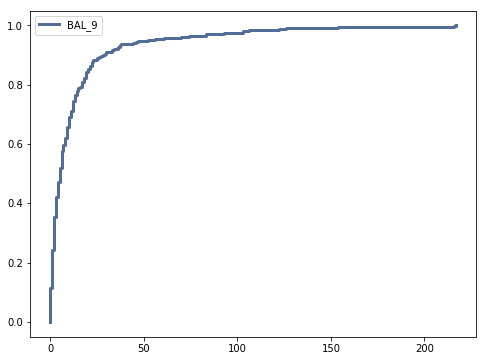

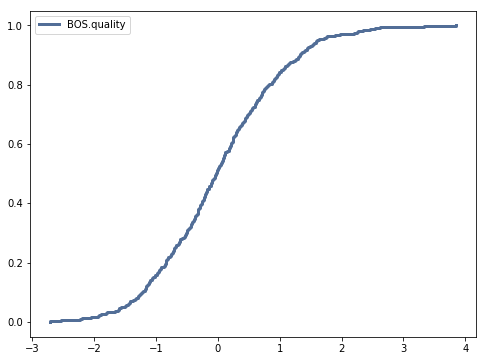

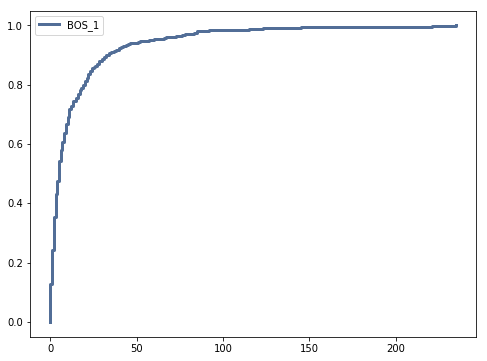

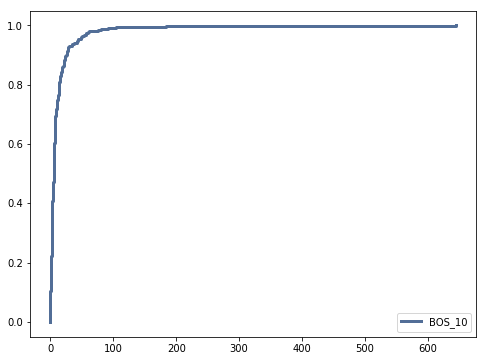

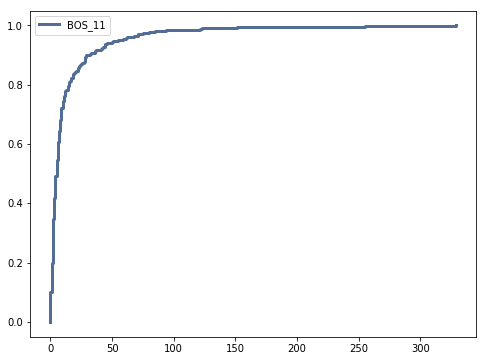

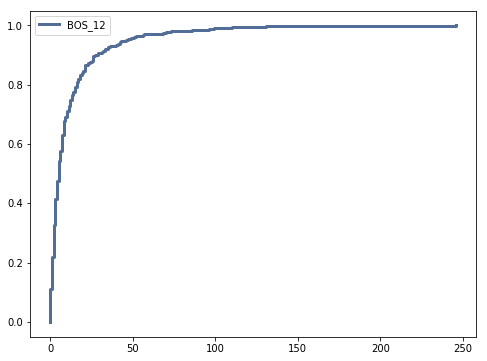

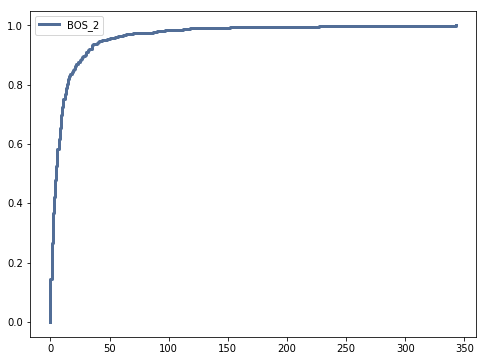

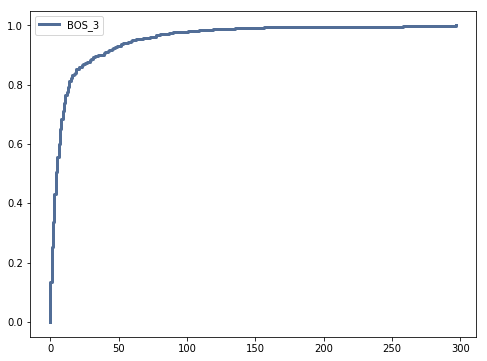

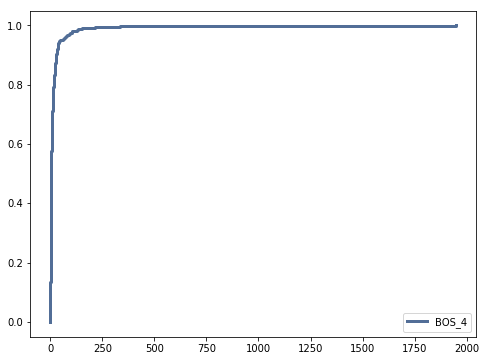

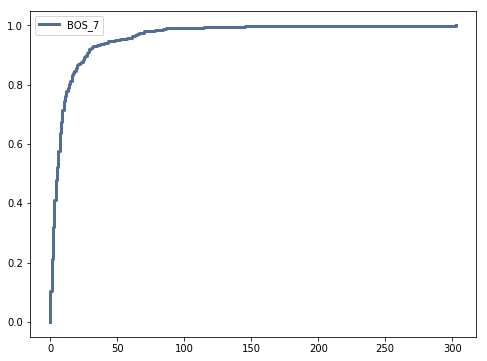

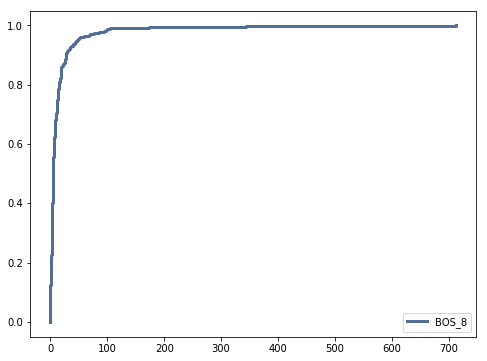

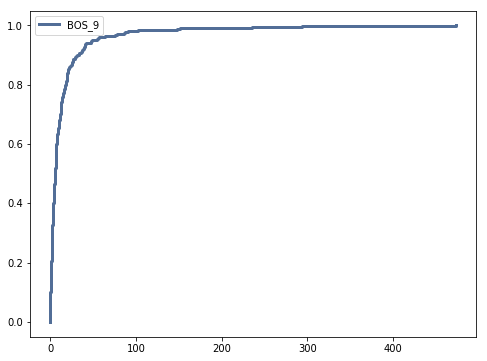

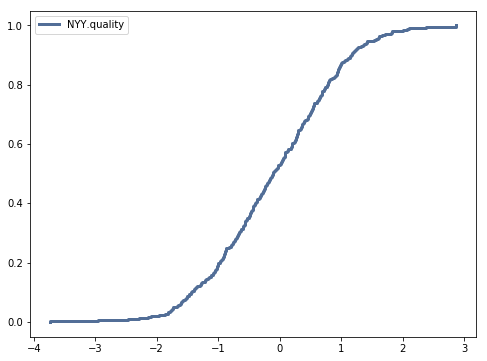

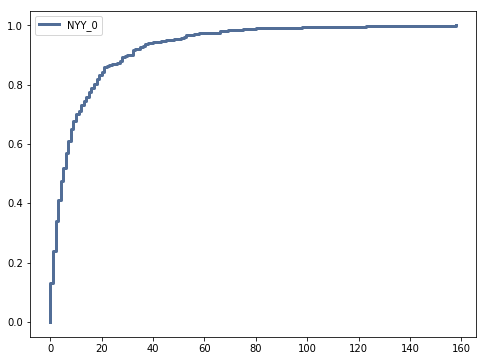

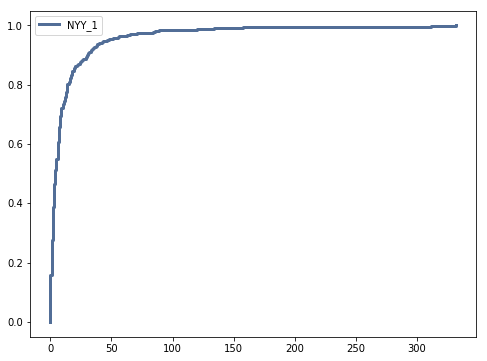

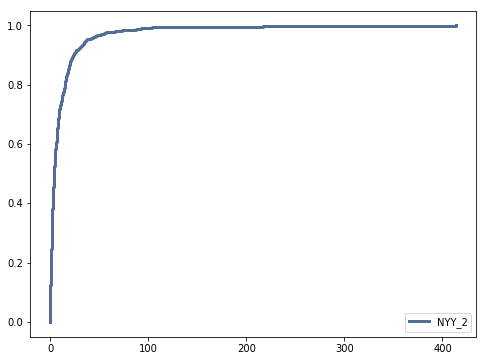

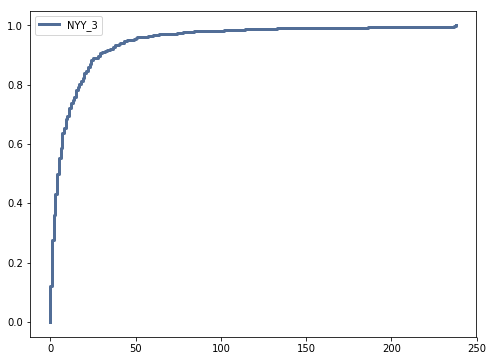

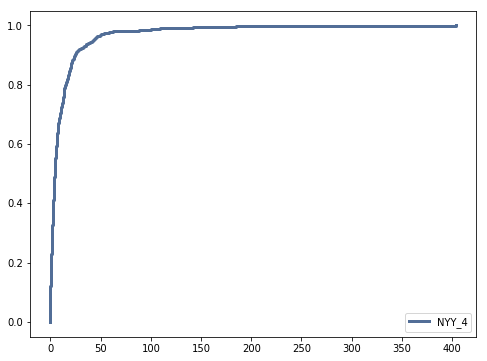

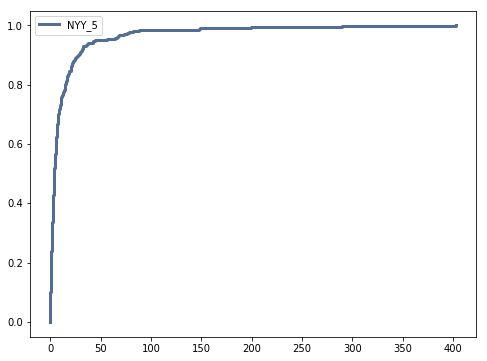

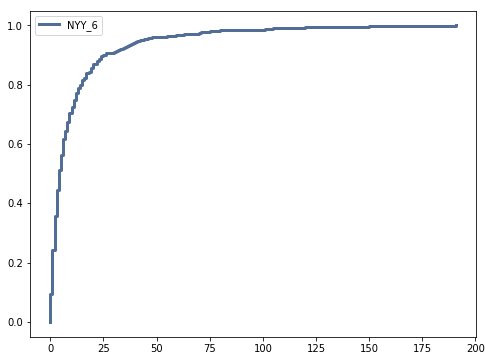

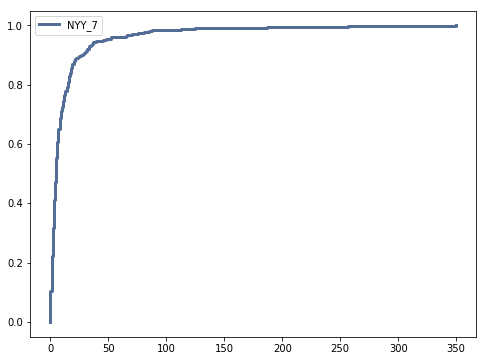

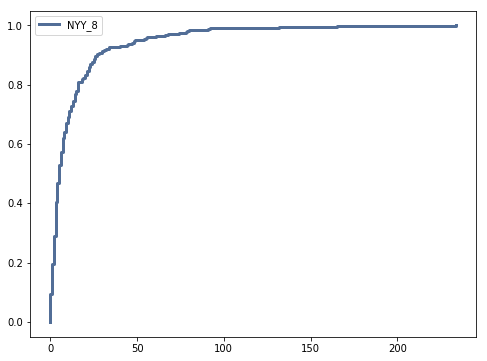

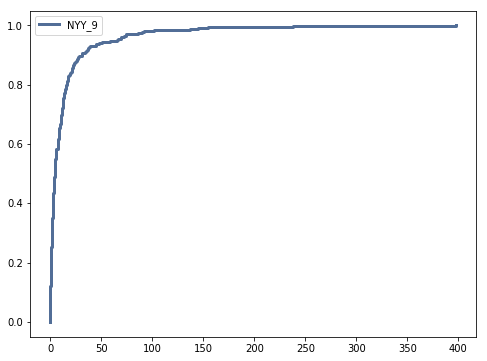

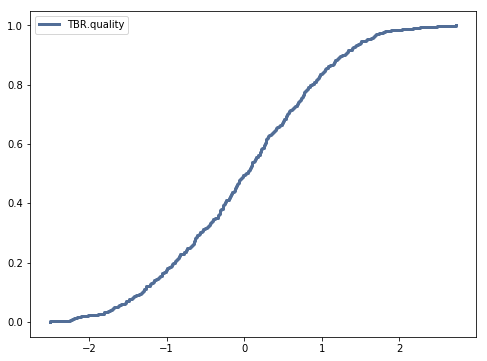

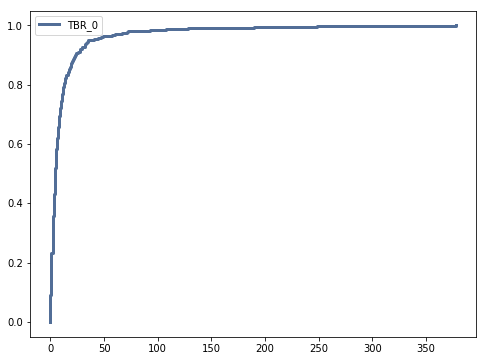

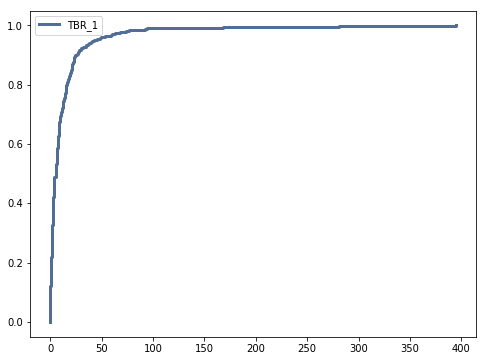

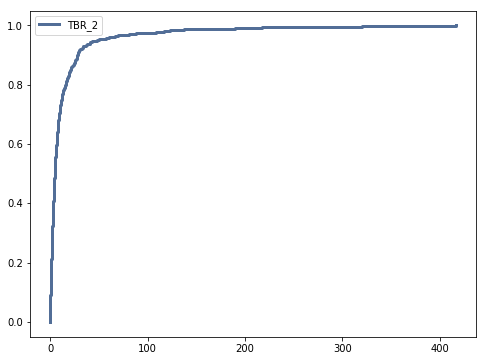

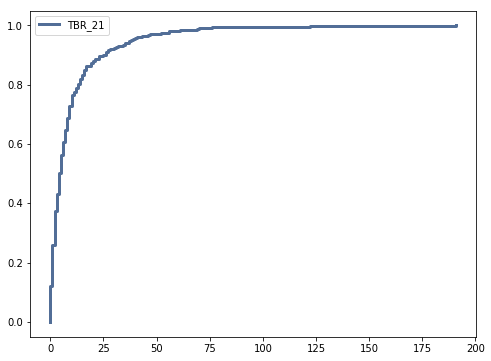

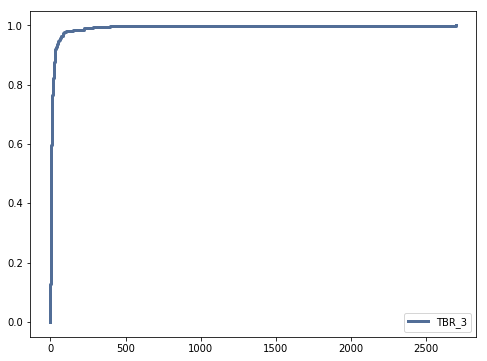

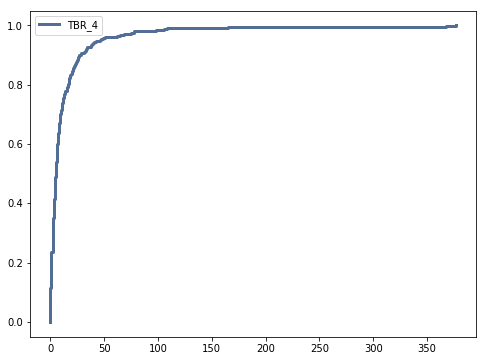

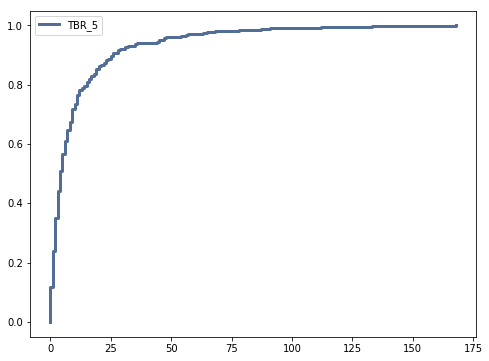

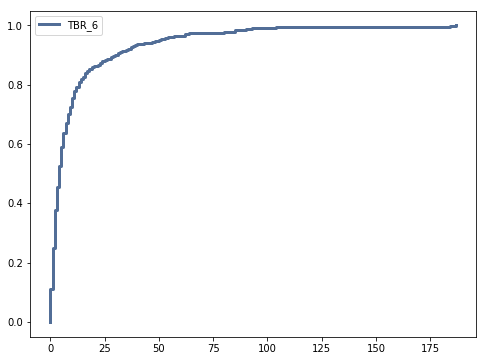

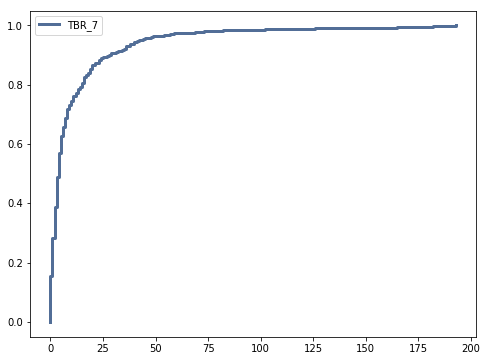

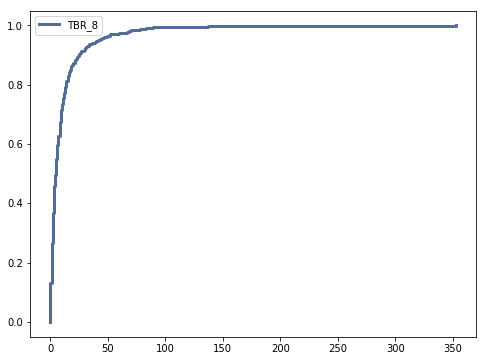

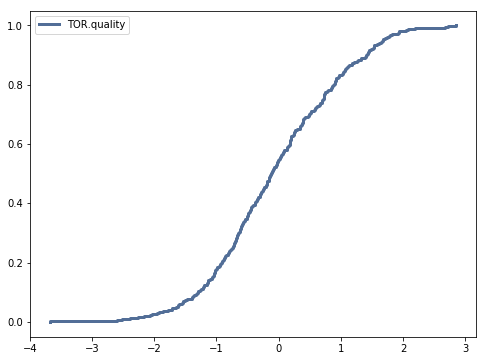

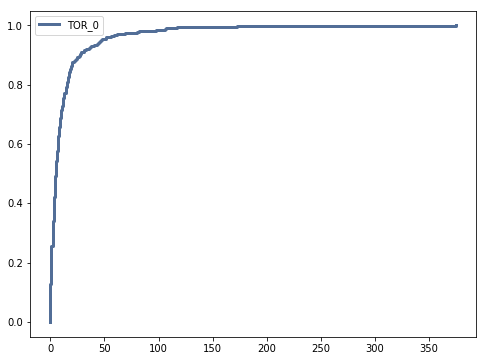

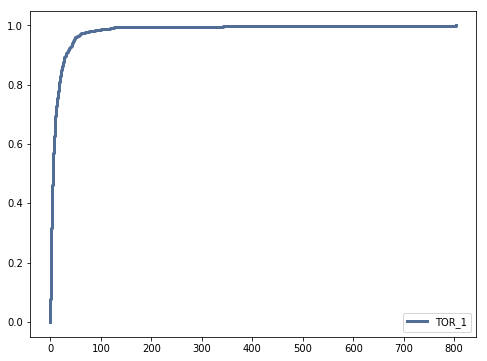

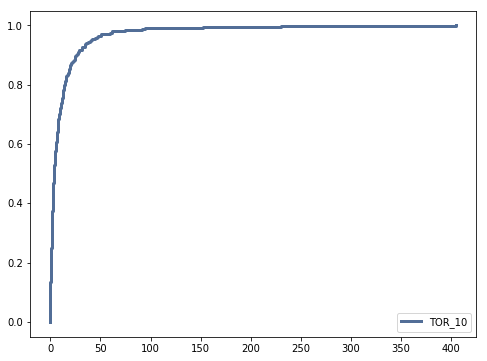

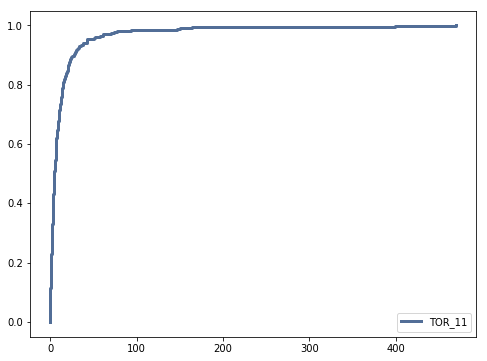

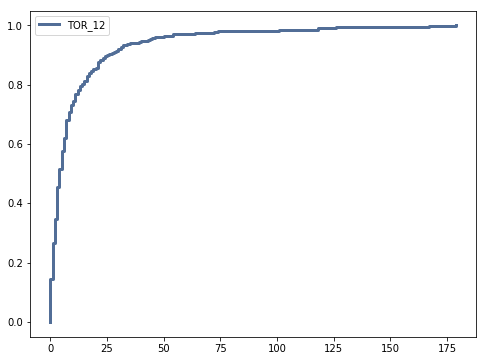

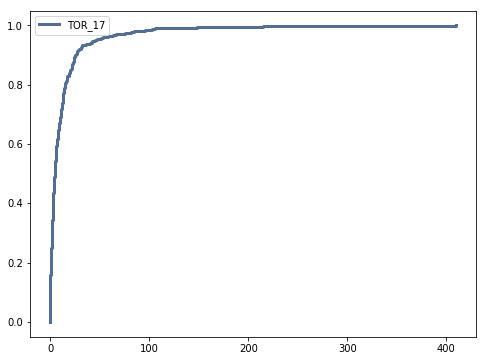

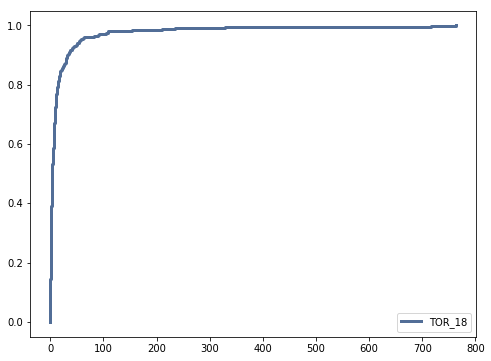

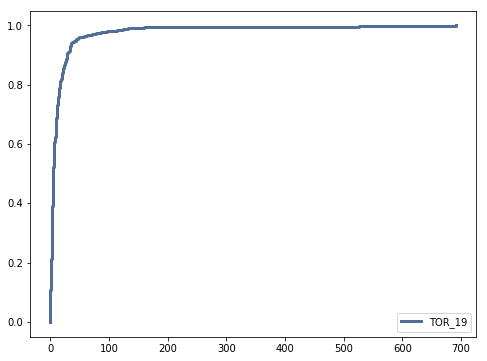

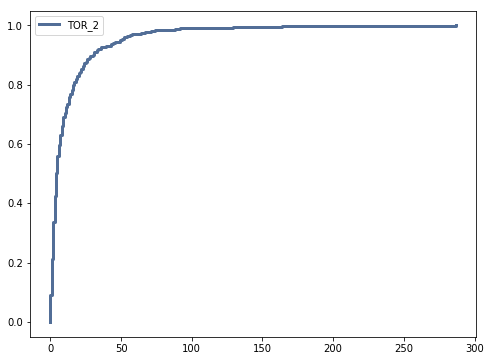

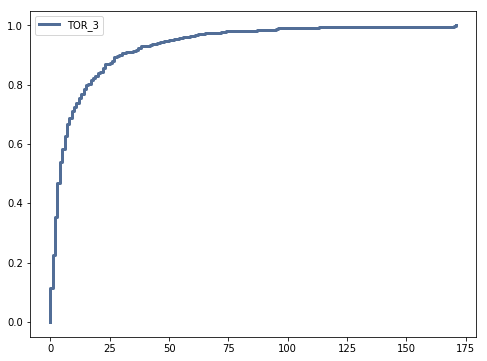

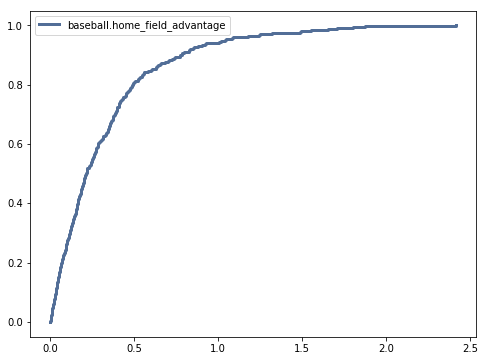

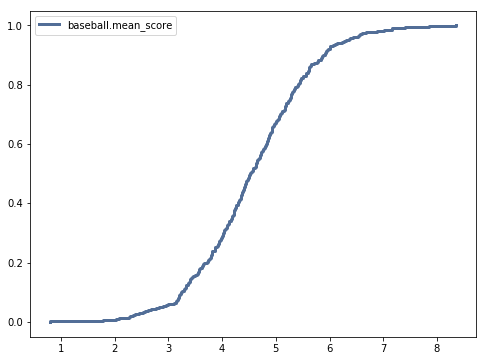

<Figure size 576x432 with 0 Axes>

In [34]:
# Inspect the prior distribution

with model:
    prior_trace = pm.sample_prior_predictive()

for k, values in sorted(prior_trace.items()):
    if k.endswith('__'):
        continue
    plotCdf(values, label=k)
    thinkplot.Show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/sam/.theano/compiledir_Darwin-18.0.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BAL.quality, TOR.quality, TBR.quality, NYY.quality, BOS.quality, baseball.home_field_advantage, baseball.mean_score]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:12<00:00, 482.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


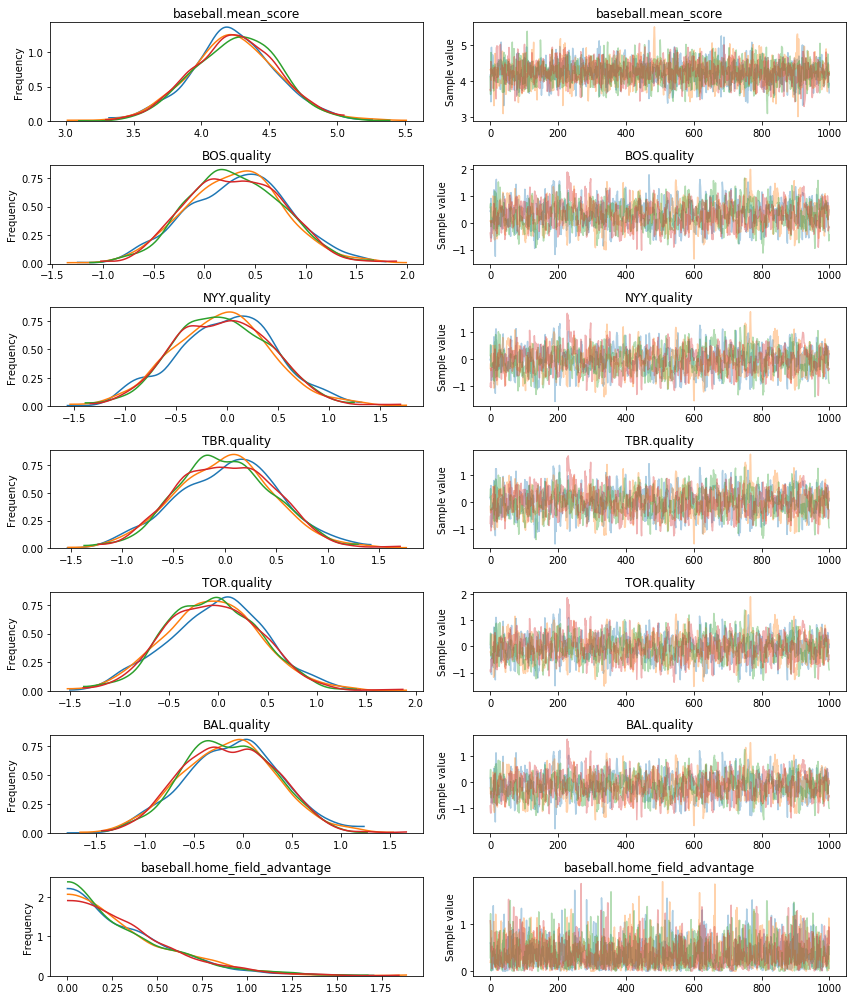

In [35]:
# Infer the posterior distributions
with model:
    trace = pm.sample(1000)
    
pm.traceplot(trace);

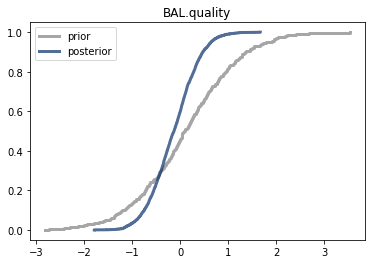

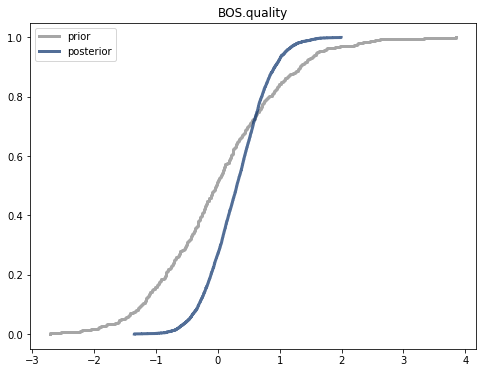

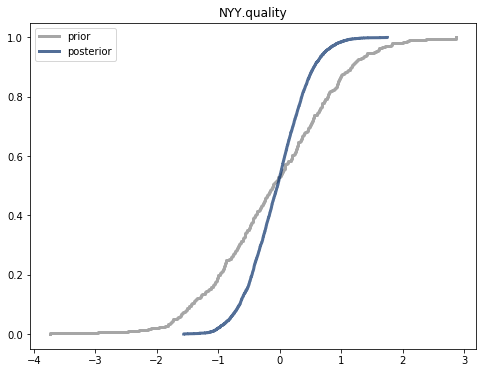

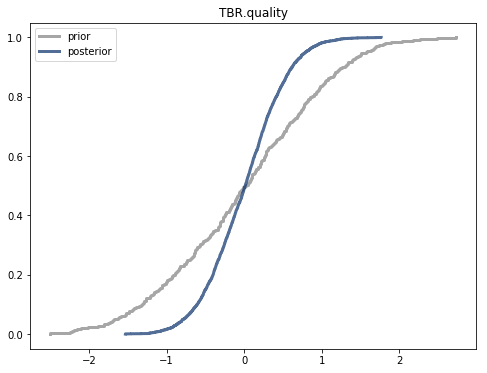

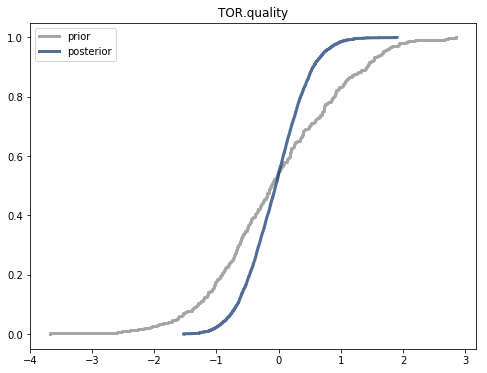

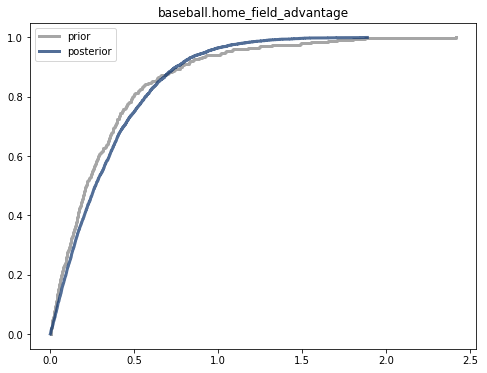

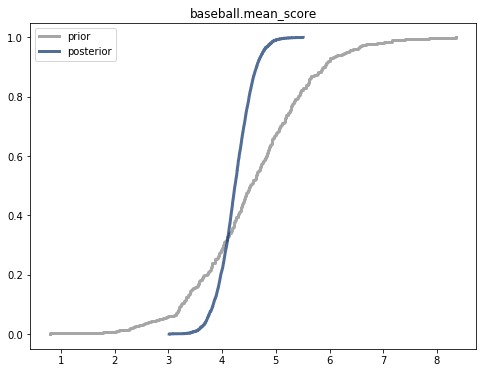

<Figure size 576x432 with 0 Axes>

In [36]:
for k in sorted(trace.varnames):
    values = trace[k]
    if k.endswith('__'):
        continue
    plotCdf(prior_trace[k], color='grey', label='prior')
    plotCdf(values, label='posterior')
    thinkplot.Config(title=k)
    thinkplot.Show()

0.9875 chance that BOS is better than NYY


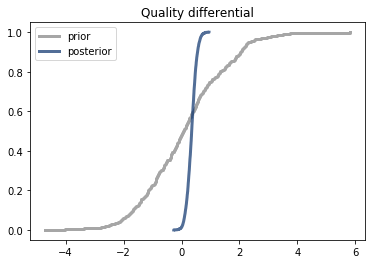

In [40]:
def plot_better(better, worse):
    plotCdf(prior_trace[f'{better}.quality'] - prior_trace[f'{worse}.quality'], label='prior', color='grey')
    plotCdf(trace[f'{better}.quality'] - trace[f'{worse}.quality'], label='posterior')
    thinkplot.Config(title='Quality differential')

    win_chance=np.mean((trace[f'{better}.quality'] - trace[f'{worse}.quality'])>0)
    print(f'{win_chance} chance that {better} is better than {worse}')

plot_better('BOS', 'NYY')
    

In [41]:
team_games['BOS'].head(10)

,Opp,Home,R,RA
1,TBR,False,4.0,6.0
2,TBR,False,1.0,0.0
3,TBR,False,3.0,2.0
4,TBR,False,2.0,1.0
7,TBR,True,3.0,2.0
8,TBR,True,10.0,3.0
9,TBR,True,8.0,7.0
10,NYY,True,14.0,1.0
11,NYY,True,7.0,10.0
12,NYY,True,6.0,3.0
